# Exploratory Data Analysis (EDA) - UJIIndoorLoc Dataset

This notebook performs comprehensive exploratory data analysis on the WiFi localization dataset.

**Analysis includes:**
- Dataset overview (training and validation)
- Building-level statistics
- Floor-level statistics per building
- WiFi Access Point (AP) statistics
- Coordinate ranges and distributions
- All results saved to Excel

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Datasets

In [2]:
# Define data paths
data_dir = Path('../../data') / 'input_data'
train_path = data_dir / 'TrainingData.csv'
val_path = data_dir / 'ValidationData.csv'

# Load datasets
print("Loading datasets...")
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

print(f"✓ Training data loaded: {df_train.shape}")
print(f"✓ Validation data loaded: {df_val.shape}")

Loading datasets...
✓ Training data loaded: (19937, 529)
✓ Validation data loaded: (1111, 529)


In [3]:
# Identify column types
wap_columns = [col for col in df_train.columns if col.startswith('WAP')]
location_columns = ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID']
metadata_columns = ['SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']

print(f"Total columns: {len(df_train.columns)}")
print(f"  - WAP (WiFi Access Points): {len(wap_columns)}")
print(f"  - Location columns: {len(location_columns)}")
print(f"  - Metadata columns: {len(metadata_columns)}")

Total columns: 529
  - WAP (WiFi Access Points): 520
  - Location columns: 4
  - Metadata columns: 5


## 1. Dataset Overview

In [4]:
# Basic statistics
overview_stats = {
    'Metric': [
        'Total Training Samples',
        'Total Validation Samples',
        'Total Samples (Combined)',
        'Number of WiFi APs',
        'Number of Buildings',
        'Number of Unique Users',
        'Number of Phone IDs',
        'Date Range (Training)',
        'Date Range (Validation)'
    ],
    'Value': [
        len(df_train),
        len(df_val),
        len(df_train) + len(df_val),
        len(wap_columns),
        df_train['BUILDINGID'].nunique(),
        df_train['USERID'].nunique(),
        df_train['PHONEID'].nunique(),
        f"{pd.to_datetime(df_train['TIMESTAMP'], unit='s').min()} to {pd.to_datetime(df_train['TIMESTAMP'], unit='s').max()}",
        f"{pd.to_datetime(df_val['TIMESTAMP'], unit='s').min()} to {pd.to_datetime(df_val['TIMESTAMP'], unit='s').max()}"
    ]
}

df_overview = pd.DataFrame(overview_stats)
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(df_overview.to_string(index=False))
print("="*60)


DATASET OVERVIEW
                  Metric                                      Value
  Total Training Samples                                      19937
Total Validation Samples                                       1111
Total Samples (Combined)                                      21048
      Number of WiFi APs                                        520
     Number of Buildings                                          3
  Number of Unique Users                                         18
     Number of Phone IDs                                         16
   Date Range (Training) 2013-05-30 10:15:24 to 2013-06-20 14:15:45
 Date Range (Validation) 2013-09-19 08:12:47 to 2013-10-08 15:57:16


## 2. Building-Level Analysis

In [5]:
# Analyze each building
building_stats = []

for building_id in sorted(df_train['BUILDINGID'].unique()):
    # Training data
    train_building = df_train[df_train['BUILDINGID'] == building_id]
    # Validation data
    val_building = df_val[df_val['BUILDINGID'] == building_id]
    
    # Get floor information
    floors_train = sorted(train_building['FLOOR'].unique())
    floors_val = sorted(val_building['FLOOR'].unique())
    all_floors = sorted(set(floors_train) | set(floors_val))
    
    # Coordinate ranges
    lon_min = min(train_building['LONGITUDE'].min(), val_building['LONGITUDE'].min())
    lon_max = max(train_building['LONGITUDE'].max(), val_building['LONGITUDE'].max())
    lat_min = min(train_building['LATITUDE'].min(), val_building['LATITUDE'].min())
    lat_max = max(train_building['LATITUDE'].max(), val_building['LATITUDE'].max())
    
    building_stats.append({
        'Building_ID': building_id,
        'Training_Fingerprints': len(train_building),
        'Validation_Fingerprints': len(val_building),
        'Total_Fingerprints': len(train_building) + len(val_building),
        'Number_of_Floors': len(all_floors),
        'Floor_List': str(all_floors),
        'Longitude_Range': f"[{lon_min:.2f}, {lon_max:.2f}]",
        'Latitude_Range': f"[{lat_min:.2f}, {lat_max:.2f}]",
        'Area_Approximate_m2': f"{abs(lon_max - lon_min) * abs(lat_max - lat_min):.2f}",
        'Unique_Spaces': train_building['SPACEID'].nunique()
    })

df_buildings = pd.DataFrame(building_stats)

print("\n" + "="*80)
print("BUILDING-LEVEL STATISTICS")
print("="*80)
print(df_buildings.to_string(index=False))
print("="*80)


BUILDING-LEVEL STATISTICS
 Building_ID  Training_Fingerprints  Validation_Fingerprints  Total_Fingerprints  Number_of_Floors                                                        Floor_List      Longitude_Range           Latitude_Range Area_Approximate_m2  Unique_Spaces
           0                   5249                      536                5785                 4              [np.int64(0), np.int64(1), np.int64(2), np.int64(3)] [-7695.94, -7585.39] [4864894.80, 4865017.36]            13549.84             78
           1                   5196                      307                5503                 4              [np.int64(0), np.int64(1), np.int64(2), np.int64(3)] [-7578.46, -7404.49] [4864809.46, 4864959.51]            26103.64             86
           2                   9492                      268                9760                 5 [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)] [-7415.16, -7299.79] [4864745.75, 4864861.76]            13384.95     

## 3. Floor-Level Analysis (Per Building)

In [6]:
# Detailed floor analysis for each building
floor_stats = []

for building_id in sorted(df_train['BUILDINGID'].unique()):
    train_building = df_train[df_train['BUILDINGID'] == building_id]
    val_building = df_val[df_val['BUILDINGID'] == building_id]
    
    # Get all floors in this building
    all_floors = sorted(set(train_building['FLOOR'].unique()) | set(val_building['FLOOR'].unique()))
    
    for floor in all_floors:
        train_floor = train_building[train_building['FLOOR'] == floor]
        val_floor = val_building[val_building['FLOOR'] == floor]
        
        # Calculate coverage (non-100 RSSI values)
        train_waps = train_floor[wap_columns]
        active_aps_train = (train_waps != 100).sum().sum()
        total_possible_train = len(train_floor) * len(wap_columns)
        coverage_train = (active_aps_train / total_possible_train * 100) if total_possible_train > 0 else 0
        
        floor_stats.append({
            'Building_ID': building_id,
            'Floor': floor,
            'Training_Fingerprints': len(train_floor),
            'Validation_Fingerprints': len(val_floor),
            'Total_Fingerprints': len(train_floor) + len(val_floor),
            'AP_Coverage_%': f"{coverage_train:.2f}",
            'Unique_Spaces': train_floor['SPACEID'].nunique(),
            'Unique_Users': train_floor['USERID'].nunique()
        })

df_floors = pd.DataFrame(floor_stats)

print("\n" + "="*90)
print("FLOOR-LEVEL STATISTICS (PER BUILDING)")
print("="*90)
print(df_floors.to_string(index=False))
print("="*90)


FLOOR-LEVEL STATISTICS (PER BUILDING)
 Building_ID  Floor  Training_Fingerprints  Validation_Fingerprints  Total_Fingerprints AP_Coverage_%  Unique_Spaces  Unique_Users
           0      0                   1059                       78                1137          2.57             54             2
           0      1                   1356                      208                1564          3.15             66             2
           0      2                   1443                      165                1608          3.42             68             2
           0      3                   1391                       85                1476          2.92             68             2
           1      0                   1368                       30                1398          3.29             49             5
           1      1                   1484                      143                1627          3.51             38             5
           1      2                   1396  

## 4. WiFi Access Point (AP) Statistics

In [7]:
# Analyze AP detection rates
ap_stats = []

for wap in wap_columns[:10]:  # Show first 10 as example
    train_detected = (df_train[wap] != 100).sum()
    val_detected = (df_val[wap] != 100).sum()
    
    train_avg_rssi = df_train[df_train[wap] != 100][wap].mean()
    val_avg_rssi = df_val[df_val[wap] != 100][wap].mean()
    
    ap_stats.append({
        'AP_Name': wap,
        'Train_Detections': train_detected,
        'Train_Detection_%': f"{train_detected / len(df_train) * 100:.2f}",
        'Val_Detections': val_detected,
        'Val_Detection_%': f"{val_detected / len(df_val) * 100:.2f}",
        'Train_Avg_RSSI': f"{train_avg_rssi:.2f}" if not np.isnan(train_avg_rssi) else 'N/A',
        'Val_Avg_RSSI': f"{val_avg_rssi:.2f}" if not np.isnan(val_avg_rssi) else 'N/A'
    })

df_aps_sample = pd.DataFrame(ap_stats)

print("\n" + "="*90)
print("WIFI ACCESS POINT STATISTICS (Sample - First 10 APs)")
print("="*90)
print(df_aps_sample.to_string(index=False))
print("="*90)


WIFI ACCESS POINT STATISTICS (Sample - First 10 APs)
AP_Name  Train_Detections Train_Detection_%  Val_Detections Val_Detection_% Train_Avg_RSSI Val_Avg_RSSI
 WAP001                18              0.09               8            0.72         -95.33       -90.62
 WAP002                19              0.10               0            0.00         -87.89          N/A
 WAP003                 0              0.00               2            0.18            N/A       -86.00
 WAP004                 0              0.00               2            0.18            N/A       -86.00
 WAP005                40              0.20               0            0.00         -92.53          N/A
 WAP006               308              1.54               0            0.00         -85.75          N/A
 WAP007               578              2.90               0            0.00         -81.65          N/A
 WAP008               677              3.40              34            3.06         -81.99       -86.35
 WAP009   

In [8]:
# Overall AP statistics
train_ap_matrix = df_train[wap_columns]
val_ap_matrix = df_val[wap_columns]

# Count APs that are detected at least once
train_active_aps = ((train_ap_matrix != 100).sum() > 0).sum()
val_active_aps = ((val_ap_matrix != 100).sum() > 0).sum()

# Average number of APs detected per fingerprint
train_avg_aps_per_fp = (train_ap_matrix != 100).sum(axis=1).mean()
val_avg_aps_per_fp = (val_ap_matrix != 100).sum(axis=1).mean()

ap_summary = {
    'Metric': [
        'Total APs in Dataset',
        'Active APs (Training)',
        'Active APs (Validation)',
        'Inactive APs (Training)',
        'Inactive APs (Validation)',
        'Avg APs per Fingerprint (Training)',
        'Avg APs per Fingerprint (Validation)',
        'Max APs in Single Fingerprint (Training)',
        'Max APs in Single Fingerprint (Validation)'
    ],
    'Value': [
        len(wap_columns),
        train_active_aps,
        val_active_aps,
        len(wap_columns) - train_active_aps,
        len(wap_columns) - val_active_aps,
        f"{train_avg_aps_per_fp:.2f}",
        f"{val_avg_aps_per_fp:.2f}",
        (train_ap_matrix != 100).sum(axis=1).max(),
        (val_ap_matrix != 100).sum(axis=1).max()
    ]
}

df_ap_summary = pd.DataFrame(ap_summary)

print("\n" + "="*60)
print("OVERALL AP SUMMARY")
print("="*60)
print(df_ap_summary.to_string(index=False))
print("="*60)


OVERALL AP SUMMARY
                                    Metric Value
                      Total APs in Dataset   520
                     Active APs (Training)   465
                   Active APs (Validation)   367
                   Inactive APs (Training)    55
                 Inactive APs (Validation)   153
        Avg APs per Fingerprint (Training) 17.99
      Avg APs per Fingerprint (Validation) 16.48
  Max APs in Single Fingerprint (Training)    51
Max APs in Single Fingerprint (Validation)    35


## 5. Coordinate Distribution Analysis

In [9]:
# Coordinate statistics for each building
coord_stats = []

for building_id in sorted(df_train['BUILDINGID'].unique()):
    train_building = df_train[df_train['BUILDINGID'] == building_id]
    val_building = df_val[df_val['BUILDINGID'] == building_id]
    
    all_data = pd.concat([train_building, val_building])
    
    coord_stats.append({
        'Building_ID': building_id,
        'Longitude_Min': f"{all_data['LONGITUDE'].min():.6f}",
        'Longitude_Max': f"{all_data['LONGITUDE'].max():.6f}",
        'Longitude_Mean': f"{all_data['LONGITUDE'].mean():.6f}",
        'Longitude_Std': f"{all_data['LONGITUDE'].std():.6f}",
        'Latitude_Min': f"{all_data['LATITUDE'].min():.6f}",
        'Latitude_Max': f"{all_data['LATITUDE'].max():.6f}",
        'Latitude_Mean': f"{all_data['LATITUDE'].mean():.6f}",
        'Latitude_Std': f"{all_data['LATITUDE'].std():.6f}"
    })

df_coords = pd.DataFrame(coord_stats)

print("\n" + "="*120)
print("COORDINATE DISTRIBUTION (PER BUILDING)")
print("="*120)
print(df_coords.to_string(index=False))
print("="*120)


COORDINATE DISTRIBUTION (PER BUILDING)
 Building_ID Longitude_Min Longitude_Max Longitude_Mean Longitude_Std   Latitude_Min   Latitude_Max  Latitude_Mean Latitude_Std
           0  -7695.938755  -7585.389976   -7639.059782     25.072780 4864894.795848 4865017.364684 4864957.884267    32.624848
           1  -7578.461972  -7404.491683   -7489.006959     49.442550 4864809.458700 4864959.505251 4864884.085808    36.209723
           2  -7415.163004  -7299.786517   -7354.123134     29.865606 4864745.745016 4864861.756103 4864815.416445    28.129531


## 6. User and Device Analysis

In [10]:
# User statistics
user_stats = []

for user_id in sorted(df_train['USERID'].unique()):
    user_data = df_train[df_train['USERID'] == user_id]
    
    user_stats.append({
        'User_ID': user_id,
        'Total_Fingerprints': len(user_data),
        'Buildings_Visited': user_data['BUILDINGID'].nunique(),
        'Floors_Visited': user_data['FLOOR'].nunique(),
        'Phone_IDs_Used': user_data['PHONEID'].nunique(),
        'Unique_Locations': user_data[['LONGITUDE', 'LATITUDE', 'FLOOR']].drop_duplicates().shape[0]
    })

df_users = pd.DataFrame(user_stats)

print("\n" + "="*80)
print("USER STATISTICS")
print("="*80)
print(df_users.to_string(index=False))
print("="*80)


USER STATISTICS
 User_ID  Total_Fingerprints  Buildings_Visited  Floors_Visited  Phone_IDs_Used  Unique_Locations
       1                2737                  1               4               1               251
       2                1091                  2               2               1               108
       3                 192                  1               1               1                20
       4                 374                  1               1               1                38
       5                 610                  1               2               1                59
       6                 980                  1               2               1                98
       7                1383                  2               2               1               119
       8                 507                  2               2               1                48
       9                1066                  2               3               1                73
   

In [11]:
# Phone device statistics
phone_stats = []

for phone_id in sorted(df_train['PHONEID'].unique()):
    phone_data = df_train[df_train['PHONEID'] == phone_id]
    
    phone_stats.append({
        'Phone_ID': phone_id,
        'Total_Fingerprints': len(phone_data),
        'Users': phone_data['USERID'].nunique(),
        'Buildings': phone_data['BUILDINGID'].nunique(),
        'Floors': phone_data['FLOOR'].nunique()
    })

df_phones = pd.DataFrame(phone_stats)

print("\n" + "="*70)
print("PHONE DEVICE STATISTICS")
print("="*70)
print(df_phones.to_string(index=False))
print("="*70)


PHONE DEVICE STATISTICS
 Phone_ID  Total_Fingerprints  Users  Buildings  Floors
        1                 507      1          2       2
        3                 610      1          1       2
        6                1383      1          2       2
        7                1596      1          2       4
        8                 913      1          2       3
       10                 440      1          2       2
       11                 498      1          1       1
       13                4516      1          3       4
       14                4835      3          3       4
       16                 192      1          1       1
       17                 841      1          2       3
       18                 374      1          1       1
       19                 980      1          1       2
       22                 724      1          2       2
       23                1091      1          2       2
       24                 437      1          1       1


## 7. Save All Results to Excel

In [12]:
# Create output directory
output_dir = Path('../../data') / 'EDA'
output_dir.mkdir(parents=True, exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = output_dir / f'EDA_Analysis_{timestamp}.xlsx'

print(f"\nSaving all results to: {output_file}")
print("="*80)

# Save all dataframes to different sheets
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet 1: Overview
    df_overview.to_excel(writer, sheet_name='1_Overview', index=False)
    print("✓ Sheet 1: Overview")
    
    # Sheet 2: Building Statistics
    df_buildings.to_excel(writer, sheet_name='2_Building_Stats', index=False)
    print("✓ Sheet 2: Building Statistics")
    
    # Sheet 3: Floor Statistics
    df_floors.to_excel(writer, sheet_name='3_Floor_Stats', index=False)
    print("✓ Sheet 3: Floor Statistics")
    
    # Sheet 4: AP Summary
    df_ap_summary.to_excel(writer, sheet_name='4_AP_Summary', index=False)
    print("✓ Sheet 4: AP Summary")
    
    # Sheet 5: AP Sample (first 50 APs)
    # Create full AP stats for top 50 most active APs
    ap_full_stats = []
    for wap in wap_columns:
        train_detected = (df_train[wap] != 100).sum()
        val_detected = (df_val[wap] != 100).sum()
        train_avg_rssi = df_train[df_train[wap] != 100][wap].mean()
        
        ap_full_stats.append({
            'AP_Name': wap,
            'Train_Detections': train_detected,
            'Train_Detection_%': train_detected / len(df_train) * 100,
            'Val_Detections': val_detected,
            'Train_Avg_RSSI': train_avg_rssi if not np.isnan(train_avg_rssi) else 0
        })
    
    df_ap_full = pd.DataFrame(ap_full_stats)
    df_ap_full = df_ap_full.sort_values('Train_Detections', ascending=False).head(50)
    df_ap_full.to_excel(writer, sheet_name='5_Top50_APs', index=False)
    print("✓ Sheet 5: Top 50 Active APs")
    
    # Sheet 6: Coordinate Distribution
    df_coords.to_excel(writer, sheet_name='6_Coordinates', index=False)
    print("✓ Sheet 6: Coordinate Distribution")
    
    # Sheet 7: User Statistics
    df_users.to_excel(writer, sheet_name='7_User_Stats', index=False)
    print("✓ Sheet 7: User Statistics")
    
    # Sheet 8: Phone Statistics
    df_phones.to_excel(writer, sheet_name='8_Phone_Stats', index=False)
    print("✓ Sheet 8: Phone Statistics")
    
    # Sheet 9: Data Quality Summary
    quality_stats = {
        'Metric': [
            'Training Samples with Missing Coordinates',
            'Validation Samples with Missing Coordinates',
            'Training Samples with No AP Detection',
            'Validation Samples with No AP Detection',
            'Duplicate Fingerprints (Training)',
            'Duplicate Fingerprints (Validation)',
            'Overall Data Completeness (Training) %',
            'Overall Data Completeness (Validation) %'
        ],
        'Value': [
            df_train[['LONGITUDE', 'LATITUDE']].isnull().any(axis=1).sum(),
            df_val[['LONGITUDE', 'LATITUDE']].isnull().any(axis=1).sum(),
            ((train_ap_matrix == 100).all(axis=1)).sum(),
            ((val_ap_matrix == 100).all(axis=1)).sum(),
            df_train.duplicated().sum(),
            df_val.duplicated().sum(),
            f"{(1 - df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1])) * 100:.2f}",
            f"{(1 - df_val.isnull().sum().sum() / (df_val.shape[0] * df_val.shape[1])) * 100:.2f}"
        ]
    }
    df_quality = pd.DataFrame(quality_stats)
    df_quality.to_excel(writer, sheet_name='9_Data_Quality', index=False)
    print("✓ Sheet 9: Data Quality Summary")

print("="*80)
print(f"\n✓✓✓ All results saved successfully to:\n    {output_file}")
print("\nThe Excel file contains 9 sheets with comprehensive EDA results.")


Saving all results to: ..\..\data\EDA\EDA_Analysis_20251105_231719.xlsx
✓ Sheet 1: Overview
✓ Sheet 2: Building Statistics
✓ Sheet 3: Floor Statistics
✓ Sheet 4: AP Summary
✓ Sheet 5: Top 50 Active APs
✓ Sheet 6: Coordinate Distribution
✓ Sheet 7: User Statistics
✓ Sheet 8: Phone Statistics
✓ Sheet 9: Data Quality Summary

✓✓✓ All results saved successfully to:
    ..\..\data\EDA\EDA_Analysis_20251105_231719.xlsx

The Excel file contains 9 sheets with comprehensive EDA results.


## Summary Statistics

In [13]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS - SUMMARY")
print("="*80)
print(f"\n📊 Dataset Statistics:")
print(f"   • Total Samples: {len(df_train) + len(df_val):,}")
print(f"   • Training: {len(df_train):,} | Validation: {len(df_val):,}")
print(f"   • WiFi Access Points: {len(wap_columns)}")
print(f"   • Buildings: {df_train['BUILDINGID'].nunique()}")
print(f"   • Total Floors: {len(set(df_train['FLOOR'].unique()) | set(df_val['FLOOR'].unique()))}")

print(f"\n🏢 Per Building:")
for _, row in df_buildings.iterrows():
    print(f"   • Building {row['Building_ID']}: {row['Total_Fingerprints']} fingerprints across {row['Number_of_Floors']} floors")

print(f"\n📡 WiFi Coverage:")
print(f"   • Active APs (Training): {train_active_aps} / {len(wap_columns)}")
print(f"   • Avg APs per Fingerprint: {train_avg_aps_per_fp:.1f}")

print(f"\n👥 Data Collection:")
print(f"   • Unique Users: {df_train['USERID'].nunique()}")
print(f"   • Phone Devices: {df_train['PHONEID'].nunique()}")

print(f"\n📁 Output:")
print(f"   • Excel file saved with 9 comprehensive sheets")
print(f"   • Location: {output_file}")
print("\n" + "="*80)


EXPLORATORY DATA ANALYSIS - SUMMARY

📊 Dataset Statistics:
   • Total Samples: 21,048
   • Training: 19,937 | Validation: 1,111
   • WiFi Access Points: 520
   • Buildings: 3
   • Total Floors: 5

🏢 Per Building:
   • Building 0: 5785 fingerprints across 4 floors
   • Building 1: 5503 fingerprints across 4 floors
   • Building 2: 9760 fingerprints across 5 floors

📡 WiFi Coverage:
   • Active APs (Training): 465 / 520
   • Avg APs per Fingerprint: 18.0

👥 Data Collection:
   • Unique Users: 18
   • Phone Devices: 16

📁 Output:
   • Excel file saved with 9 comprehensive sheets
   • Location: ..\..\data\EDA\EDA_Analysis_20251105_231719.xlsx



## Visualizations (Optional)

Generate quick visualizations for better understanding.

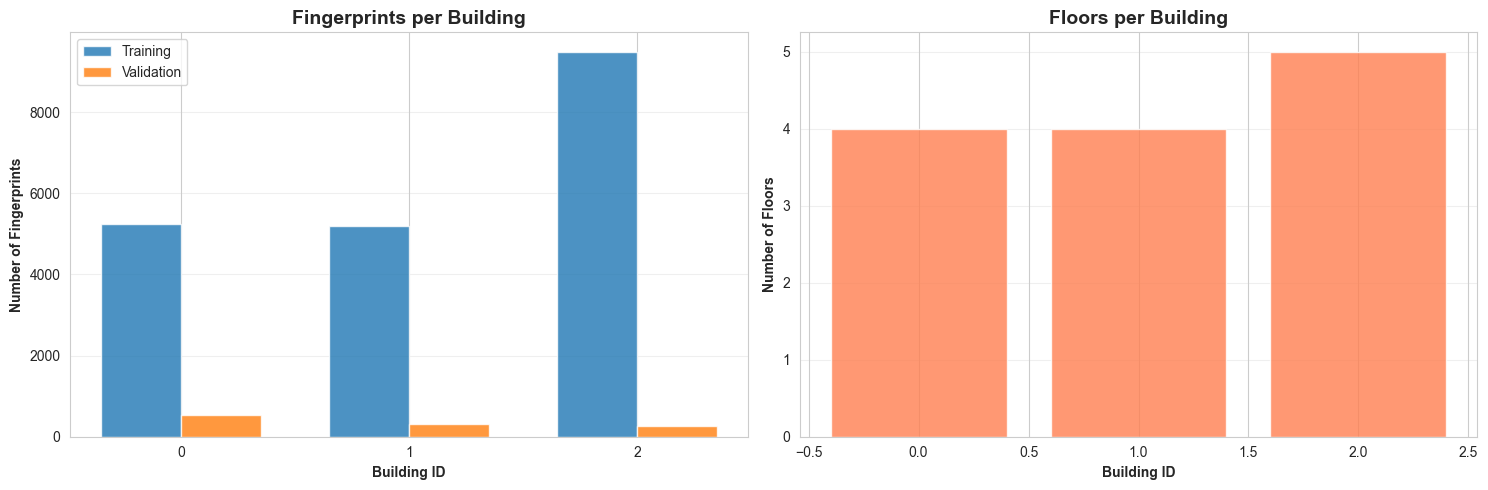

✓ Saved visualization: ..\..\data\EDA\building_overview.png


In [14]:
# Plot 1: Fingerprints per Building
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training vs Validation per building
buildings = df_buildings['Building_ID']
x = np.arange(len(buildings))
width = 0.35

ax1.bar(x - width/2, df_buildings['Training_Fingerprints'], width, label='Training', alpha=0.8)
ax1.bar(x + width/2, df_buildings['Validation_Fingerprints'], width, label='Validation', alpha=0.8)
ax1.set_xlabel('Building ID', fontweight='bold')
ax1.set_ylabel('Number of Fingerprints', fontweight='bold')
ax1.set_title('Fingerprints per Building', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(buildings)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Floors per building
ax2.bar(buildings, df_buildings['Number_of_Floors'], color='coral', alpha=0.8)
ax2.set_xlabel('Building ID', fontweight='bold')
ax2.set_ylabel('Number of Floors', fontweight='bold')
ax2.set_title('Floors per Building', fontweight='bold', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'building_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved visualization: {output_dir / 'building_overview.png'}")

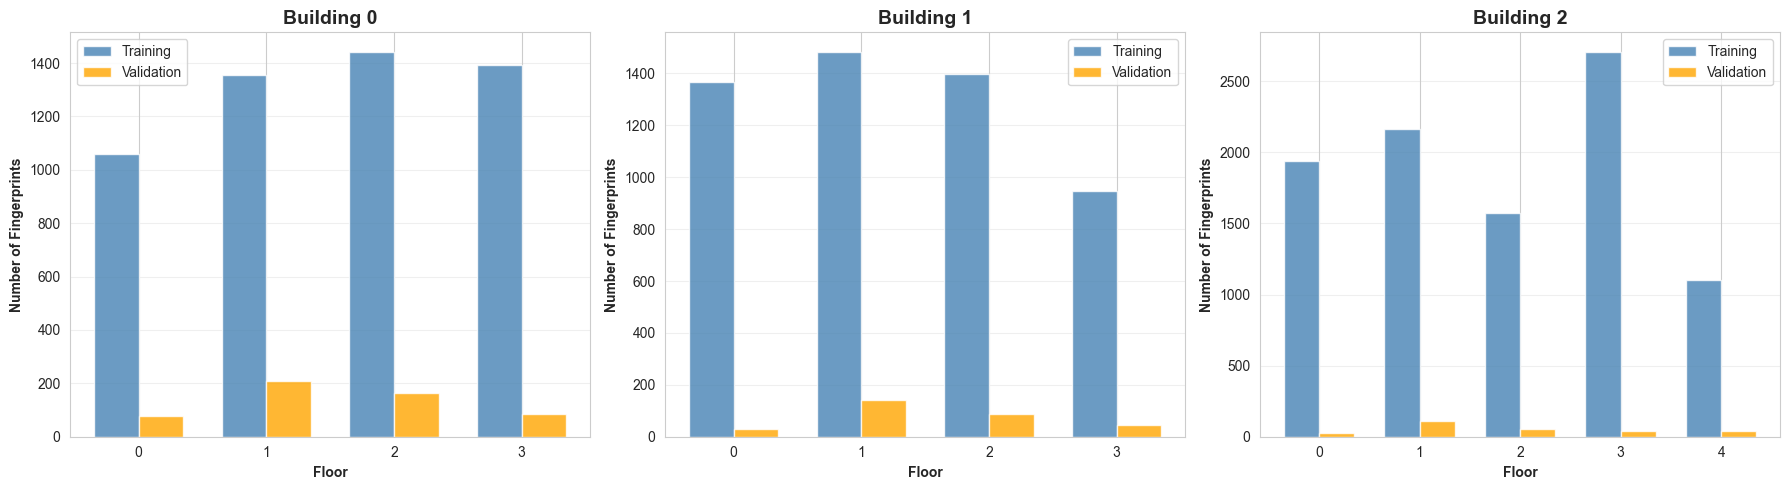

✓ Saved visualization: ..\..\data\EDA\floor_distribution.png


In [15]:
# Plot 2: Fingerprints per Floor (for each building)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, building_id in enumerate(sorted(df_train['BUILDINGID'].unique())):
    building_floors = df_floors[df_floors['Building_ID'] == building_id]
    
    floors = building_floors['Floor']
    train_counts = building_floors['Training_Fingerprints']
    val_counts = building_floors['Validation_Fingerprints']
    
    x = np.arange(len(floors))
    width = 0.35
    
    axes[i].bar(x - width/2, train_counts, width, label='Training', alpha=0.8, color='steelblue')
    axes[i].bar(x + width/2, val_counts, width, label='Validation', alpha=0.8, color='orange')
    axes[i].set_xlabel('Floor', fontweight='bold')
    axes[i].set_ylabel('Number of Fingerprints', fontweight='bold')
    axes[i].set_title(f'Building {building_id}', fontweight='bold', fontsize=14)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(floors)
    axes[i].legend()
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'floor_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved visualization: {output_dir / 'floor_distribution.png'}")

## Analysis Complete!

All EDA results have been saved to:
- Excel file with 9 comprehensive sheets
- Visualization plots (PNG files)

Location: `data/EDA/`